# filter the cell_types

In [ ]:
import scanpy as sc

adata = sc.read_h5ad('lung_disease.h5ad')

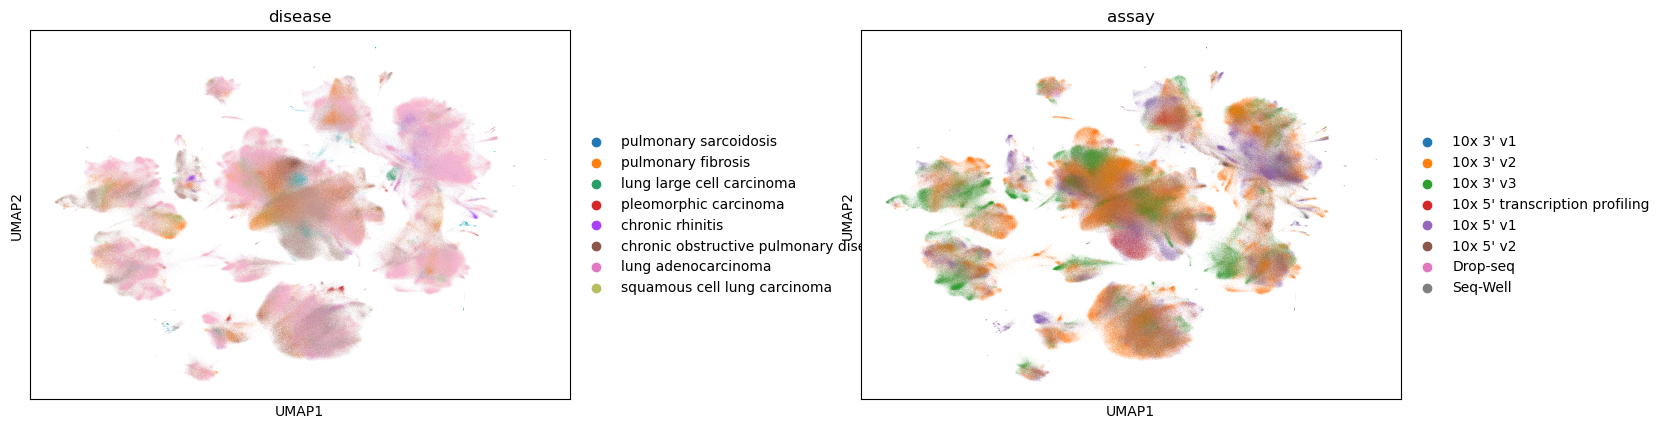

In [ ]:
# adata.obs['disease'],adata.obs['assay']=='10x 3\' v3'
sc.pl.umap(adata, color=['cell_type'], wspace=0.4,save_path='umap_cell_type.png',dpi=600)
plt.savefig()

In [2]:
# adata.obs['disease'].value_counts()

adata[(adata.obs['disease']=='COVID-19') | (adata.obs['disease']=='normal'), :]

View of AnnData object with n_obs × n_vars = 1646860 × 56239
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'sex_ontology_term_id', "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'core_or_extension', 'dataset', 'fresh_or_frozen', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'reannotation_type', 'sample', 'scanvi_label', 'sequencing_platform', 'smoking_status', 'study', 'subject_type', 'tissue_coarse_unharmonized', 'tissue_detailed_unha

In [28]:
adata.obs['assay'].value_counts()
# adata[(adata.obs['assay']=="10x 5' transcription profiling") :]

assay
10x 3' v2                         1029484
10x 5' v1                          500292
10x 3' v3                          479730
10x 5' transcription profiling     126024
Drop-seq                            57887
Seq-Well                            44756
10x 5' v2                           37081
10x 3' v1                            7193
Name: count, dtype: int64

In [8]:
cov_norm_adata = adata[(adata.obs['assay']=="10x 3' v3") & ((adata.obs['disease']=="normal") | (adata.obs['disease']=="COVID-19"))]

In [10]:
sc.pp.highly_variable_genes(cov_norm_adata,n_top_genes=2000,subset=True)

/disk/tanbowen/anaconda3/envs/knockpath/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:664: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}


In [12]:
cov_norm_adata.write_h5ad('lung_cov_norm.h5ad')

In [1]:
import scanpy as sc
cov_norm_adata=sc.read_h5ad('lung_cov_norm.h5ad')

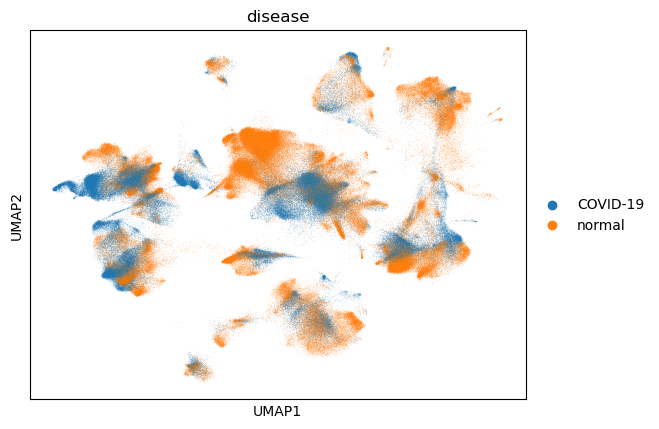

In [8]:
import matplotlib.pyplot as plt
# sc.pl.umap(cov_norm_adata,color=['disease'],save_path='umap_disease.png',kdpi=600)

sc.pl.umap(cov_norm_adata, color=['disease'], show=False)  # show=False 只生成对象不弹窗
plt.savefig("umap.png", dpi=1000, bbox_inches="tight")

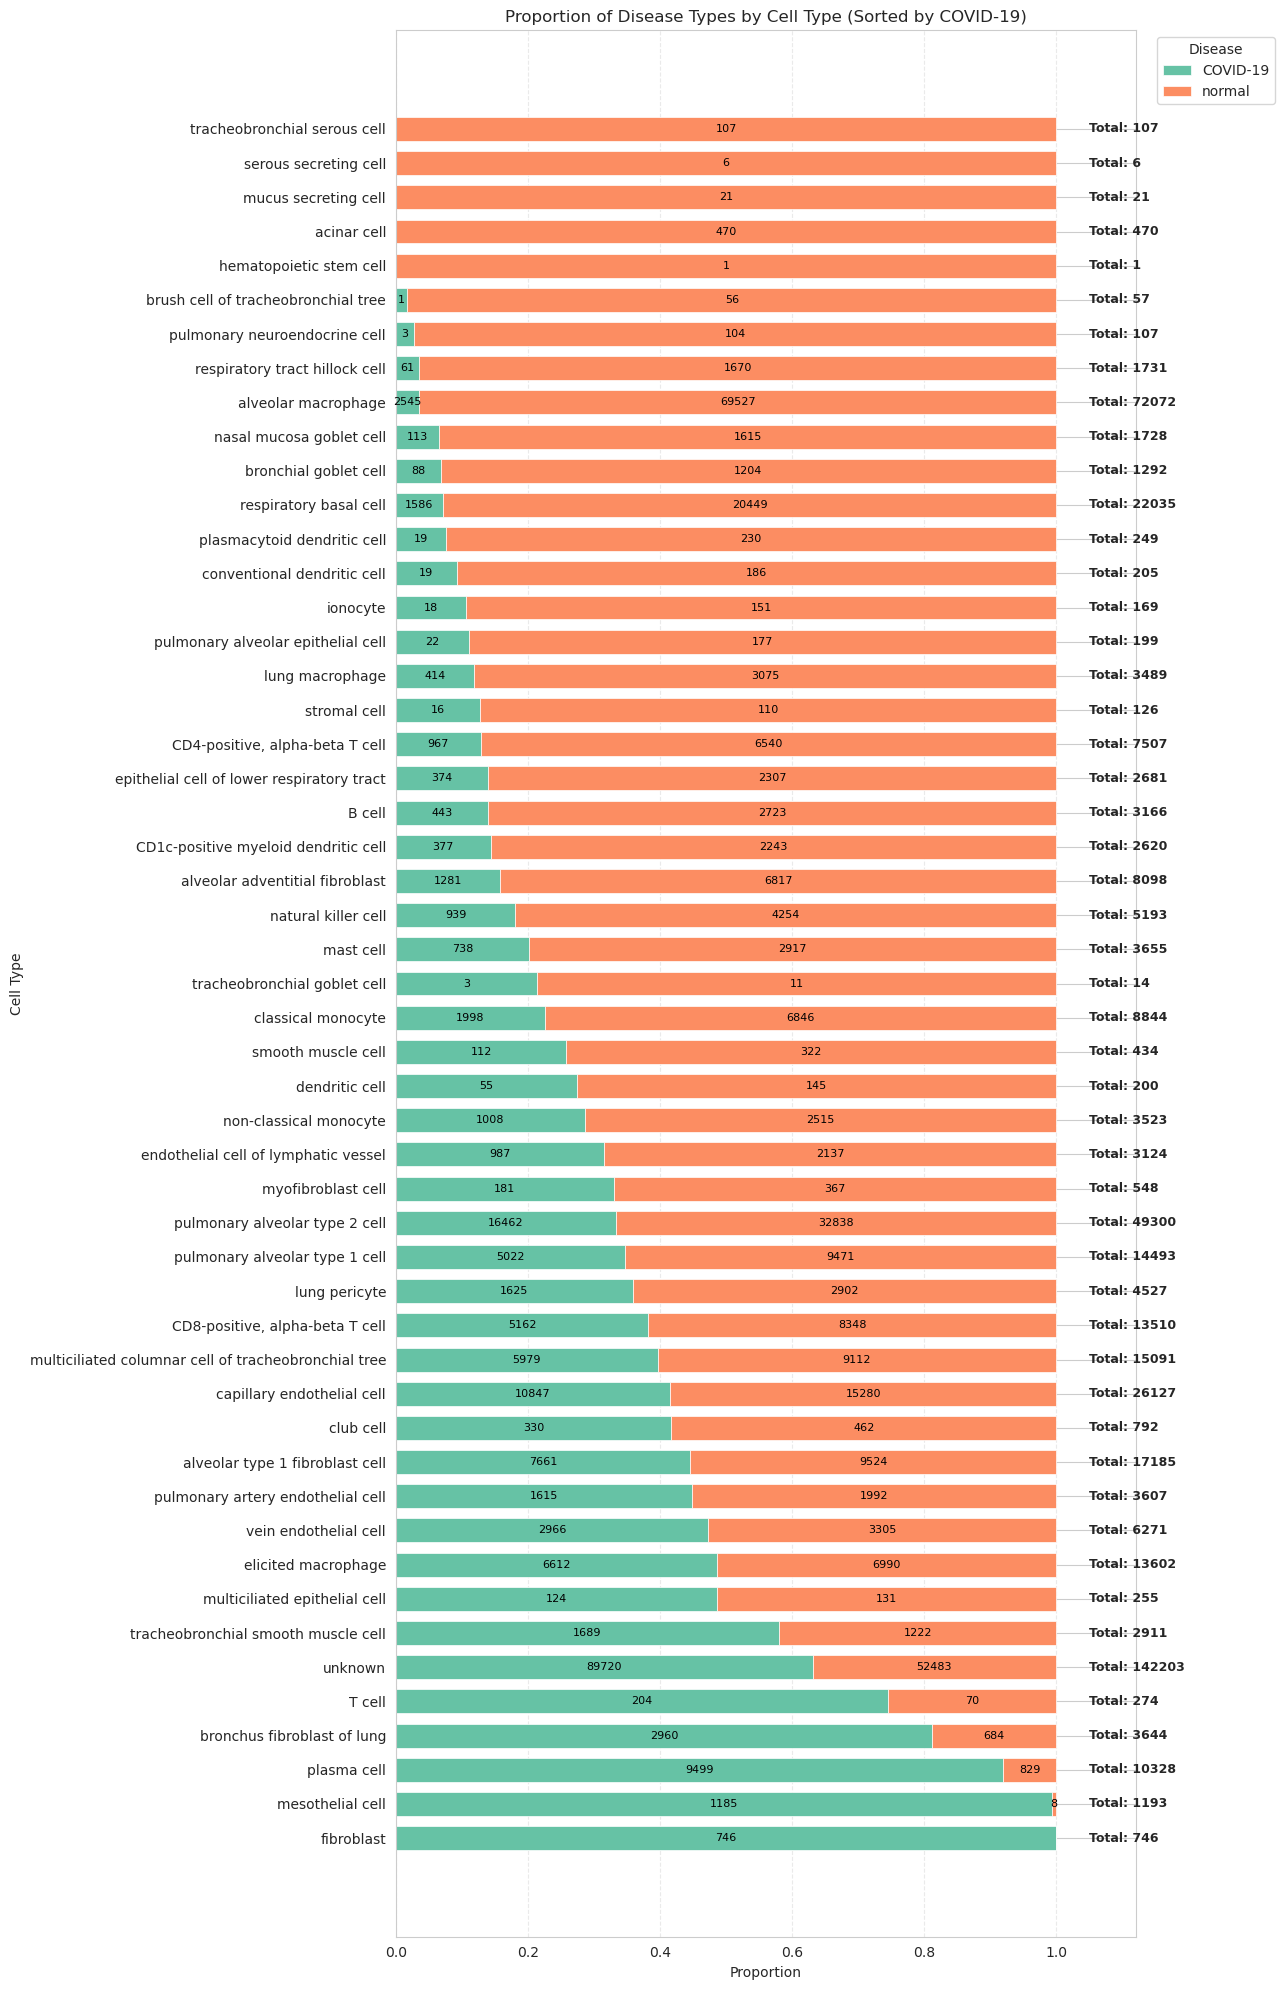

Cell types with COVID-19 proportion between 40%-60%:
disease                              COVID-19    normal
cell_type                                              
tracheobronchial smooth muscle cell  0.580213  0.419787
multiciliated epithelial cell        0.486275  0.513725
elicited macrophage                  0.486105  0.513895
vein endothelial cell                0.472971  0.527029
pulmonary artery endothelial cell    0.447741  0.552259
alveolar type 1 fibroblast cell      0.445796  0.554204
club cell                            0.416667  0.583333
capillary endothelial cell           0.415164  0.584836


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Sort by COVID-19 proportion (descending)
ct_disease_prop = pd.crosstab(
    cov_norm_adata.obs['cell_type'],
    cov_norm_adata.obs['disease'],
    normalize='index'
)
ct_disease_prop_sorted = ct_disease_prop.sort_values('COVID-19', ascending=False)

# Raw counts aligned with the sorted proportions
ct_counts = pd.crosstab(
    cov_norm_adata.obs['cell_type'],
    cov_norm_adata.obs['disease']
)
ct_counts_sorted = ct_counts.loc[ct_disease_prop_sorted.index]

# Horizontal stacked bar plot with spacing
sns.set_style("whitegrid")
colors = sns.color_palette("Set2", n_colors=ct_disease_prop_sorted.shape[1])
y_positions = np.arange(len(ct_disease_prop_sorted))
bar_height = 0.7
left = np.zeros(len(ct_disease_prop_sorted))

fig, ax = plt.subplots(figsize=(13, 20))

for (disease, color) in zip(ct_disease_prop_sorted.columns, colors):
    proportions = ct_disease_prop_sorted[disease].values
    counts = ct_counts_sorted[disease].values
    bars = ax.barh(
        y_positions,
        proportions,
        left=left,
        height=bar_height,
        color=color,
        edgecolor="white",
        linewidth=0.5,
        label=disease,
    )
    for bar, count in zip(bars, counts):
        if count == 0:
            continue
        x = bar.get_x() + bar.get_width() / 2
        y = bar.get_y() + bar.get_height() / 2
        r, g, b, _ = bar.get_facecolor()
        text_color = "black" if 0.299 * r + 0.587 * g + 0.114 * b > 0.6 else "white"
        ax.text(x, y, f"{int(count)}", ha="center", va="center", fontsize=8, color=text_color)
    left += proportions

ax.set_yticks(y_positions)
ax.set_yticklabels(ct_disease_prop_sorted.index)
ax.set_xlim(0, 1.12)
ax.set_xlabel("Proportion")
ax.set_ylabel("Cell Type")
ax.set_title("Proportion of Disease Types by Cell Type (Sorted by COVID-19)")
ax.legend(title="Disease", bbox_to_anchor=(1.02, 1), loc="upper left")
ax.grid(axis="x", linestyle="--", alpha=0.4)

# Annotate total counts at the end of each bar
total_counts = ct_counts_sorted.sum(axis=1)
for y_pos, total in zip(y_positions, total_counts):
    ax.text(1.05, y_pos, f"Total: {int(total)}", ha="left", va="center", fontsize=9, fontweight="bold")

plt.tight_layout()
plt.show()

# Filter cell types with COVID-19 proportion between 40%-60% (after sorting)
filtered_cell_types = ct_disease_prop_sorted[
    (ct_disease_prop_sorted['COVID-19'] >= 0.4) & (ct_disease_prop_sorted['COVID-19'] <= 0.6)
]
print("Cell types with COVID-19 proportion between 40%-60%:")
print(filtered_cell_types)

# select multiciliated epithelial cell
#

In [43]:
cov_norm_adata[cov_norm_adata.obs['cell_type']=='CD4-positive, alpha-beta T cell'].obs['disease'].value_counts()

disease
normal      6540
COVID-19     967
Name: count, dtype: int64

In [6]:
filtered_covid_adata = covid_adata[covid_adata.obs['cell_type'].isin(filtered_cell_types.index)]

/data/tanbowen/anaconda3/envs/knockpath/lib/python3.11/site-packages/scanpy/plotting/_utils.py:465: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


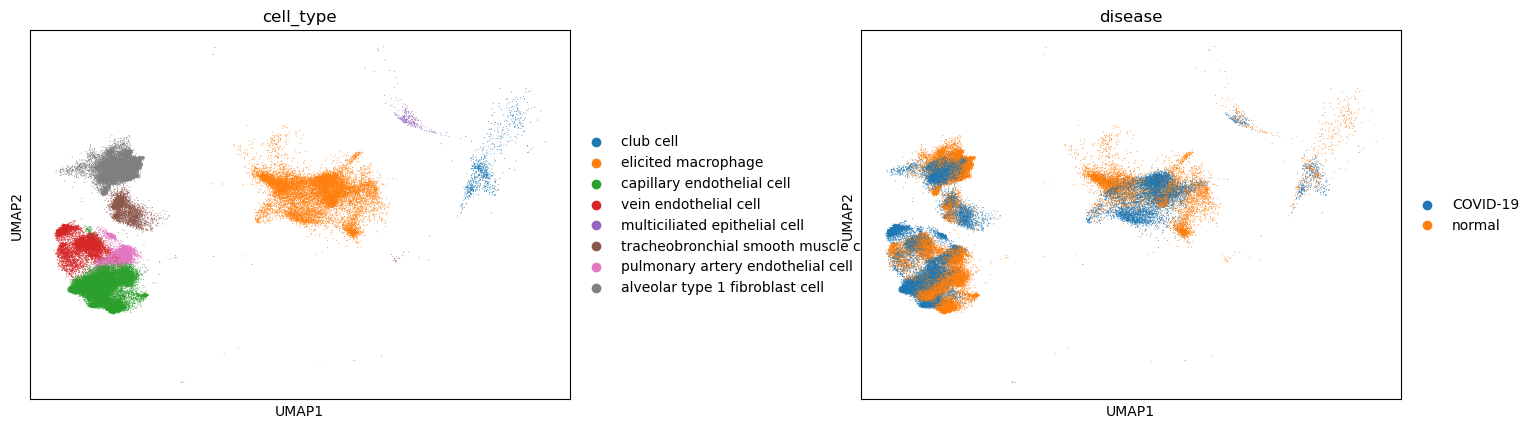

In [7]:
filtered_covid_adata

sc.pl.umap(filtered_covid_adata, color=['cell_type', 'disease'], wspace=0.4, ncols=2)

In [8]:
# filtered_covid_adata.write_h5ad('lung_disease_filtered.h5ad')

filtered_covid_adata

AnnData object with n_obs × n_vars = 70750 × 56239
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'sex_ontology_term_id', "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'core_or_extension', 'dataset', 'fresh_or_frozen', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'reannotation_type', 'sample', 'scanvi_label', 'sequencing_platform', 'smoking_status', 'study', 'subject_type', 'tissue_coarse_unharmonized', 'tissue_detailed_unharmonized',

# analyze the filtered_covid_adata

In [13]:
import scanpy as sc
import numpy as np

sc.settings.verbosity = 3

file_name = 'lung_disease_filtered.h5ad'

old_adata = sc.read_h5ad(file_name)
old_adata.obs['cell_type'].value_counts()

cell_type
capillary endothelial cell             26127
alveolar type 1 fibroblast cell        17185
elicited macrophage                    13602
vein endothelial cell                   6271
pulmonary artery endothelial cell       3607
tracheobronchial smooth muscle cell     2911
club cell                                792
multiciliated epithelial cell            255
Name: count, dtype: int64

In [14]:
# cell_type
cell_type='pulmonary artery endothelial cell'


# create a new AnnData object
adata=sc.AnnData(X=old_adata[old_adata.obs['cell_type'] == cell_type].raw.X,raw=old_adata[old_adata.obs['cell_type'] == cell_type].raw)

# label cells and genes(var and var_names cannot have the same data)
adata.var_names=old_adata[old_adata.obs['cell_type'] == cell_type].var['feature_name']
adata.obs_names=old_adata[old_adata.obs['cell_type'] == cell_type].obs_names

adata.obs['disease']=old_adata[old_adata.obs['cell_type'] == cell_type].obs['disease'].values

# QC metrics
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

/data/tanbowen/anaconda3/envs/knockpath/lib/python3.11/site-packages/anndata/_core/anndata.py:864: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['A1BG', 'A1BG-AS1', 'A1CF', 'A2M', 'A2M-AS1']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")


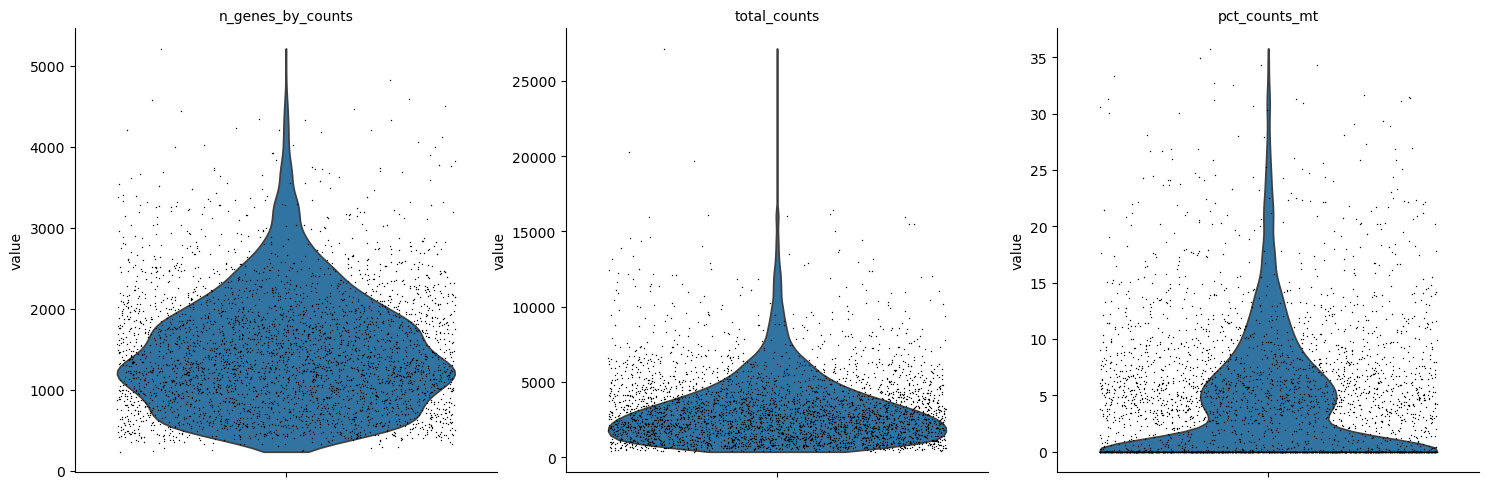

In [15]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

In [16]:
adata = adata[
    (adata.obs.n_genes_by_counts < 4500)
    & (adata.obs.n_genes_by_counts > 200)
    & (adata.obs.total_counts < 20000)
    & (adata.obs.pct_counts_mt < 20),
    :,
].copy()
adata.layers["counts"] = adata.X.copy()

/data/tanbowen/anaconda3/envs/knockpath/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [17]:
adata

AnnData object with n_obs × n_vars = 3487 × 56239
    obs: 'disease', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'counts'

In [18]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=10)

adata

filtered out 40283 genes that are detected in less than 10 cells


/data/tanbowen/anaconda3/envs/knockpath/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/data/tanbowen/anaconda3/envs/knockpath/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 3487 × 15956
    obs: 'disease', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    layers: 'counts'

In [ ]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata,n_top_genes=2000,inplace=True)

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [28]:
adata=adata[:,adata.var['highly_variable']]
sc.pp.scale(adata, max_value=10)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/data/tanbowen/anaconda3/envs/knockpath/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:299: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


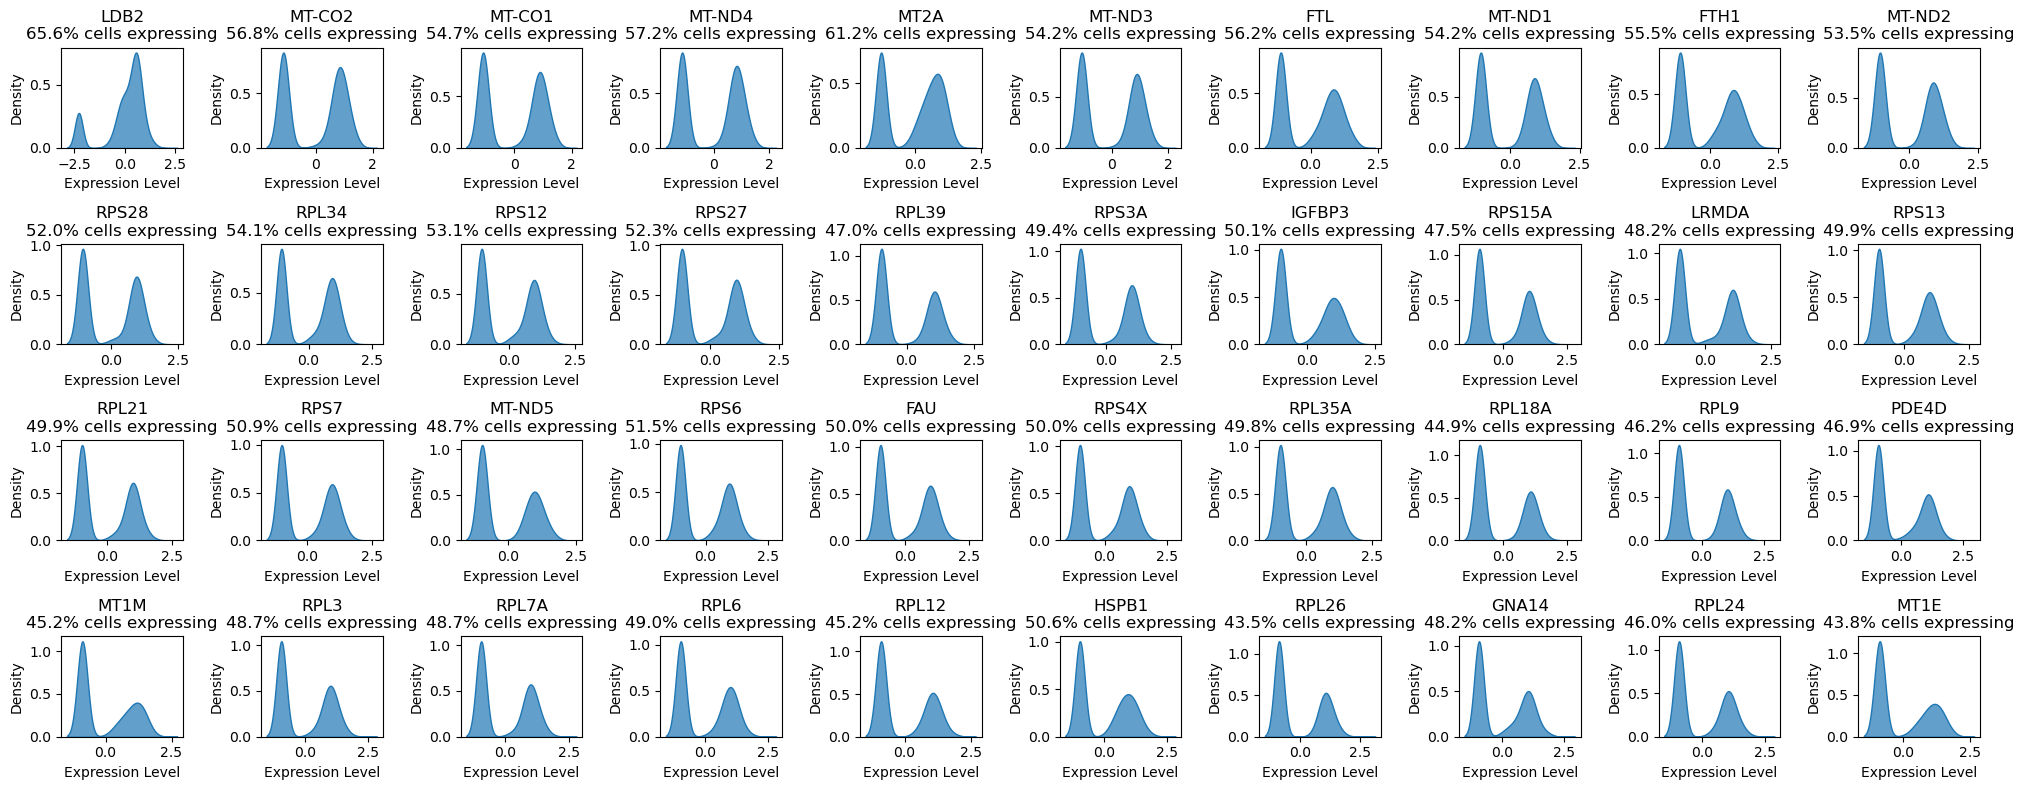

In [35]:
import seaborn as sns

# Plot density plots for the top highly variable genes
import matplotlib.pyplot as plt

# Get the top 10 most highly variable genes
# top_genes = adata.var.sort_values('dispersions_norm', ascending=False).head(10).index
top_genes = adata.var.sort_values('means', ascending=False).head(40).index

# Create subplots for gene density visualization
fig, axes = plt.subplots(4, 10, figsize=(20, 8))
axes = axes.flatten()

for i, gene in enumerate(top_genes):
    # Get gene expression data
    gene_expression = adata[:, gene].X.toarray().flatten()
    
    # Calculate the percentage of cells expressing this gene
    expressing_cells = (gene_expression > 0).sum()
    total_cells = len(gene_expression)
    frequency = expressing_cells / total_cells * 100
    
    # Plot density plot
    sns.kdeplot(gene_expression, ax=axes[i], fill=True, alpha=0.7)
    axes[i].set_title(f'{gene}\n{frequency:.1f}% cells expressing')
    axes[i].set_xlabel('Expression Level')
    axes[i].set_ylabel('Density')

plt.tight_layout()
plt.show()


In [ ]:
cell_type='capillary endothelial cell'
seed=42
n_top_genes=2000
n_sample=8000

# create a new AnnData object
adata=sc.AnnData(X=old_adata[old_adata.obs['cell_type'] == cell_type].raw.X)
# label cells and genes(var and var_names cannot have the same data)
adata.var_names=old_adata[old_adata.obs['cell_type'] == cell_type].var['feature_name']
adata.obs_names=old_adata[old_adata.obs['cell_type'] == cell_type].obs_names

adata.obs['disease']=old_adata[old_adata.obs['cell_type'] == cell_type].obs['disease'].values
# adata.var_names_make_unique()
# adata.obs_names_make_unique()

adata

sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_genes(adata, min_cells=10)
# Quality control on count data
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

adata = adata[adata.obs.n_genes_by_counts < 7000, :]
adata = adata[adata.obs.pct_counts_mt < 15, :]


sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
np.random.seed(seed)
sc.pp.highly_variable_genes(adata,n_top_genes=n_top_genes)
adata=adata[:, adata.var.highly_variable]

# Select 1500 cells from each category in adata.obs['diabetes_model']
category_1 = adata.obs['disease'].unique()[0]
category_2 = adata.obs['disease'].unique()[1]
print(f"category_1: {category_1}, category_2: {category_2}")
print(f"category_1 cells: {sum(adata.obs['disease'] == category_1)}, category_2cells: {sum(adata.obs['disease'] == category_2)}")

if n_sample is None:
    adata.layers['lognorm'] = adata.X.toarray().copy()
else:
    cells_category_1 = np.random.choice(adata[adata.obs['disease'] == category_1].obs_names, n_sample, replace=False)
    cells_category_2 = np.random.choice(adata[adata.obs['disease'] == category_2].obs_names, n_sample, replace=False)
    selected_cells = np.concatenate([cells_category_1, cells_category_2])
    adata = adata[selected_cells]
    

#     adata.layers['lognorm'] = adata.X.toarray().copy()

#     return adata

/data/tanbowen/anaconda3/envs/knockpath/lib/python3.11/site-packages/anndata/_core/anndata.py:864: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['A1BG', 'A1BG-AS1', 'A1CF', 'A2M', 'A2M-AS1']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")


filtered out 2907 cells that have less than 500 genes expressed


/data/tanbowen/anaconda3/envs/knockpath/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/data/tanbowen/anaconda3/envs/knockpath/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


filtered out 34818 genes that are detected in less than 10 cells


/data/tanbowen/anaconda3/envs/knockpath/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


normalizing counts per cell


/data/tanbowen/anaconda3/envs/knockpath/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/data/tanbowen/anaconda3/envs/knockpath/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
category_1: COVID-19, category_2: normal
category_1 cells: 8491, category_2cells: 14338


In [39]:
adata

View of AnnData object with n_obs × n_vars = 22829 × 21421
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [37]:
import numpy as np

# Count the number of False and True values
mt_counts = np.unique(adata.var_names.str.startswith("MT-"), return_counts=True)
mt_counts = dict(zip(mt_counts[0], mt_counts[1]))
print(mt_counts)



{False: 56202, True: 37}


# Data Description

In [1]:
import scanpy as sc
adata=sc.read_h5ad("lung_cov_norm.h5ad")
adata

AnnData object with n_obs × n_vars = 479730 × 2000
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'sex_ontology_term_id', "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'core_or_extension', 'dataset', 'fresh_or_frozen', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'reannotation_type', 'sample', 'scanvi_label', 'sequencing_platform', 'smoking_status', 'study', 'subject_type', 'tissue_coarse_unharmonized', 'tissue_detailed_unharmonized',

In [2]:
adata.obs['cell_type'].value_counts()

cell_type
unknown                                                 142203
alveolar macrophage                                      72072
pulmonary alveolar type 2 cell                           49300
capillary endothelial cell                               26127
respiratory basal cell                                   22035
alveolar type 1 fibroblast cell                          17185
multiciliated columnar cell of tracheobronchial tree     15091
pulmonary alveolar type 1 cell                           14493
elicited macrophage                                      13602
CD8-positive, alpha-beta T cell                          13510
plasma cell                                              10328
classical monocyte                                        8844
alveolar adventitial fibroblast                           8098
CD4-positive, alpha-beta T cell                           7507
vein endothelial cell                                     6271
natural killer cell                          

In [9]:
macro_subset = adata[adata.obs['cell_type'] == 'elicited macrophage']

In [10]:
macro_subset

View of AnnData object with n_obs × n_vars = 13602 × 2000
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'sex_ontology_term_id', "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'core_or_extension', 'dataset', 'fresh_or_frozen', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'reannotation_type', 'sample', 'scanvi_label', 'sequencing_platform', 'smoking_status', 'study', 'subject_type', 'tissue_coarse_unharmonized', 'tissue_detailed_unharmo

/disk/tanbowen/anaconda3/envs/knockpath/lib/python3.11/site-packages/scanpy/plotting/_utils.py:465: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


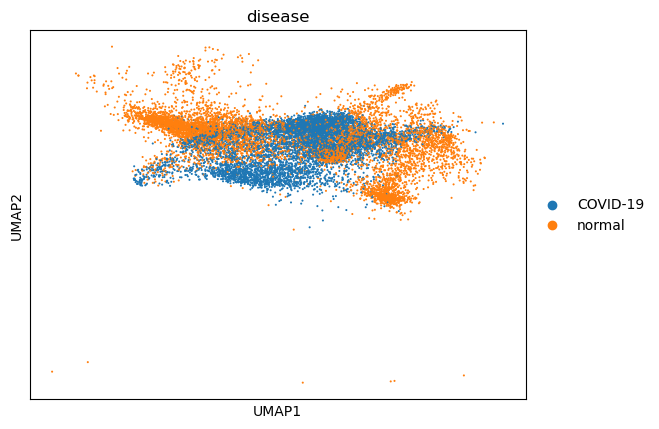

In [11]:
sc.pl.umap(macro_subset, color=['disease'])

/tmp/ipykernel_2171484/1605911069.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=status_counts.index, y=status_counts.values, palette='Set2')


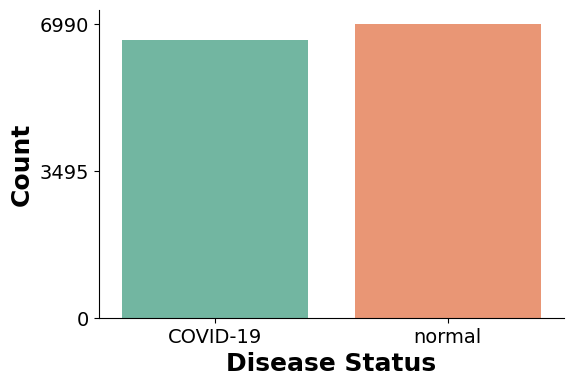

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
# Count the occurrences of each diabetes status
status_counts = macro_subset.obs['disease'].value_counts()

# Create a bar plot
plt.figure(figsize=(6, 4))
sns.barplot(x=status_counts.index, y=status_counts.values, palette='Set2')
plt.xlabel('Disease Status',weight='bold', size=18)
plt.ylabel('Count',weight='bold', size=18)
plt.yticks([0,max(status_counts.values)//2,max(status_counts.values)],size=14)
plt.xticks(size=14)
sns.despine()
plt.savefig("macro_disease_status_counts.pdf", bbox_inches="tight")
plt.show()